## Chargement propre des données

In [1]:
import pandas as pd
import numpy as np


In [2]:
X_train  = pd.read_csv('data/X_train_78VdSWL.csv')
X_test = pd.read_csv('data/X_test_XKVc4no.csv')
Y_train = pd.read_csv('data/y_train_u0UkKEh.csv')

## Reconstruction
| Heure | sin | cos |
| ----- | --- | --- |
| 00h   | 0   | 1   |
| 06h   | 1   | 0   |
| 12h   | 0   | -1  |
| 18h   | -1  | 0   |
| 24h   | 0   | 1   |

on a besoin du sinus et du cosinus pour avoir les coordonnées complètes : ✅ sin + cos :

chaque heure correspond à un point unique

aucune ambiguïté

👉 (sin, cos) = coordonnées polaires complètes

Un modèle ML (KNN, régression, réseau de neurones) :

travaille avec des distances

cherche des similarités

Avec sin/cos :

23h30 et 00h00 sont proches

12h est naturellement opposé à minuit

la périodicité est respectée
La consommation électrique :

a un pic le matin

un pic le soir

un creux la nuit

un comportement différent le week-end
Alors mathématiquement :

distance(23, 0) = 23

alors que dans la réalité :

23h30 et 00h00 sont très proches

👉 Le modèle ML pense :

“23h et 0h sont très différents”

❌ Contresens physique

In [4]:
start_date = "2023-01-09 00:00:00"

time_index_train = pd.date_range(
    start=start_date,
    periods=len(X_train),
    freq="30min"
)

time_index_test = pd.date_range(
    start=time_index_train[-1] + pd.Timedelta(minutes=30),
    periods=len(X_test),
    freq="30min"
)
X_train["datetime"] = time_index_train
X_test["datetime"]  = time_index_test


In [5]:
X_train["hour"] = X_train["datetime"].dt.hour + X_train["datetime"].dt.minute / 60
X_test["hour"]  = X_test["datetime"].dt.hour  + X_test["datetime"].dt.minute / 60


In [6]:
X_train["hour_sin"] = np.sin(2 * np.pi * X_train["hour"] / 24)
X_train["hour_cos"] = np.cos(2 * np.pi * X_train["hour"] / 24)

X_test["hour_sin"] = np.sin(2 * np.pi * X_test["hour"] / 24)
X_test["hour_cos"] = np.cos(2 * np.pi * X_test["hour"] / 24)


In [7]:
X_train["dow"] = X_train["datetime"].dt.dayofweek
X_test["dow"]  = X_test["datetime"].dt.dayofweek


In [9]:
X_train.drop(
    columns=["Horodate", "datetime", "hour", "dow"],
    inplace=True,
    errors="ignore"
)

X_test.drop(
    columns=["Horodate", "datetime", "hour", "dow"],
    inplace=True,
    errors="ignore"
)


In [ ]:
clients_to_predict = set(Y_train.columns)

feature_columns = [
    c for c in X_train.columns
    if c not in clients_to_predict
]




In [31]:
X_train_clean = X_train[feature_columns]


In [ ]:
X_test_clean = X_test.reindex(
    columns=feature_columns,
    fill_value=0
)
print(X_train_clean.shape)
print(X_test_clean.shape)





(1057, 19302)
(1057, 20004)


X_train_clean  
→ StandardScaler  
→ PCA  
→ Modèle (KNN / Ridge)  
→ Y_train  
→ Prédiction sur X_test_clean  


In [50]:
stds = X_train_clean.std(axis=0)
non_constant_cols = stds[stds > 0].index


In [51]:
X_train_clean = X_train_clean[non_constant_cols]
X_test_clean  = X_test_clean[non_constant_cols]


In [55]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler_X = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train_clean)
X_test_scaled  = scaler_X.transform(X_test_clean)

Y_train = Y_train.fillna(0)
scaler_Y = StandardScaler()
Y_train_scaled = scaler_Y.fit_transform(Y_train)


In [53]:
np.isnan(X_train_scaled).sum()
pca = PCA(n_components=300)

X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca  = pca.transform(X_test_scaled)


## Entraîner le KNN

In [56]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(
    n_neighbors=5,
    weights="distance",
    metric="euclidean",
    n_jobs=-1
)

knn.fit(X_train_pca, Y_train_scaled)


KNeighborsRegressor(metric='euclidean', n_jobs=-1, weights='distance')

In [57]:
Y_train_pred_scaled = knn.predict(X_train_pca)
Y_train_pred = scaler_Y.inverse_transform(Y_train_pred_scaled)


In [58]:
Y_test_scaled = knn.predict(X_test_pca)
Y_test = scaler_Y.inverse_transform(Y_test_scaled)


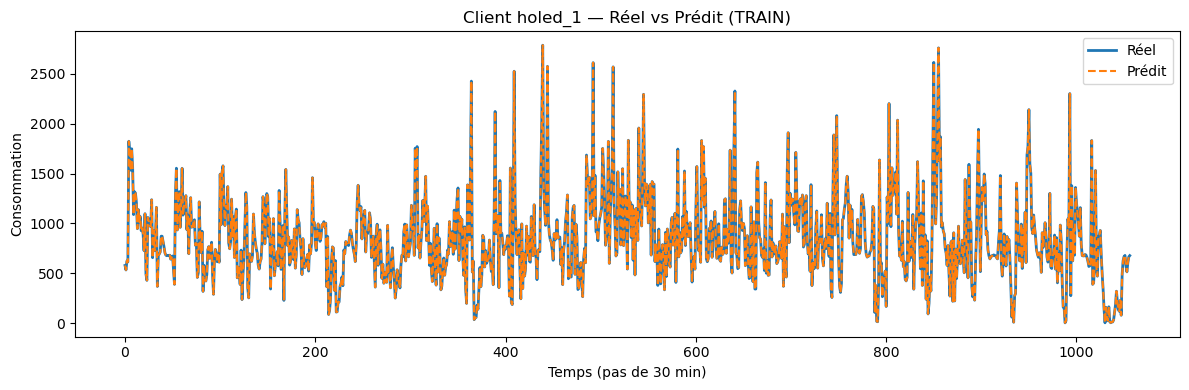

In [ ]:
import matplotlib.pyplot as plt

client_id = Y_train.columns[0]

plt.figure(figsize=(12, 4))-
plt.plot(Y_train[client_id].values, label="Réel", linewidth=2)
plt.plot(Y_train_pred[:, 0], label="Prédit", linestyle="--")
plt.title(f"Client {client_id} — Réel vs Prédit (TRAIN)")
plt.xlabel("Temps (pas de 30 min)")
plt.ylabel("Consommation")
plt.legend()
plt.tight_layout()
plt.show()
